In [1]:
from aicspylibczi import CziFile
import czifile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.animation as animation
import IPython
from IPython.display import HTML
import ffmpeg

In [2]:
from scipy.stats import sigmaclip
from multiprocessing import Pool
import os
import cv2
from skimage.measure import label, regionprops_table # version at least 0.22
from skimage.filters import threshold_otsu # version at least 0.22

In [3]:
from utils import *

In [4]:
processed_video_files = [
    ("processed", 3),
    ('processed', 6),
    ('processed', 9),
]
mip_video_files = [
    ('mip', 3),
    ('mip', 6),
    ('mip', 9),
]

In [5]:
class VideoDataMIP:
    def __init__(self, files):
        self.data = {
        }
        
        for category, num in files:
            print(f"Loading in MIP {num}")
            assert category == 'mip', "Can't load non Mip file"
            file = {}
            file['video'] = get_file(category, num)
            
            frames, shp = file['video'].read_image(C=0)
            frames = scale_img(frames.squeeze())
            file['frames'] = frames
            print(f"frames {num}: {frames.shape}")
            file['masks'] = binarize_video(frames)

            self.data[num] = file


    def extract_all_traces(self, file_num, sequence_length=-1, hist_length=2):
        # hist length is how many frames of history
        frames, masks = self.data[file_num]['frames'], self.data[file_num]['masks']
        N = len(frames)
        s = 0
        all_traces = []
        all_videos = []
        if(sequence_length < 0):
            data, videos = extract_traces(frames, masks, hist=hist_length)
        else:
            for i in range(N // sequence_length):
                print(f"Extracting traces from {s}:{s+sequence_length}")
                data, videos = extract_traces(frames[s:s+sequence_length], masks[s:s+sequence_length], hist=hist_length)
                s += sequence_length
                all_traces = all_traces + data
                all_videos = all_videos + videos
            
            if(N % sequence_length > 0):
                data, videos = extract_traces(frames[-1*sequence_length:], masks[-1*sequence_length:], hist=hist_length)
                all_traces = all_traces + data
                all_videos = all_videos + videos

        self.data[file_num]['traces'] = all_traces
        self.data[file_num]['trace_videos'] = all_videos

In [6]:
videos = VideoDataMIP(mip_video_files)

Loading in MIP 3
Loading dicty_factin_pip3-03_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 90)}]
frames 3: (90, 2048, 474)
Loading in MIP 6
Loading dicty_factin_pip3-06_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 241)}]
frames 6: (241, 2048, 474)
Loading in MIP 9
Loading dicty_factin_pip3-09_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 241)}]
frames 9: (241, 2048, 474)


In [12]:
videos.extract_all_traces(3, 10, 4)

Extracting traces from 0:10
Extracting cell  0
Extracting cell  1
Extracting cell  2
Extracting cell  3
Extracting cell  4
Extracting cell  5
Extracting cell  6
Extracting traces from 10:20
Extracting cell  0
Extracting cell  1
Extracting cell  2
Extracting cell  3
Extracting cell  4
Extracting cell  5
Extracting cell  6
Extracting cell  7
Extracting traces from 20:30
Extracting cell  0
Extracting cell  1
Extracting cell  2
Extracting cell  3
Extracting cell  4
Extracting cell  5
Extracting cell  6
Extracting cell  7
Extracting cell  8
Extracting traces from 30:40
Extracting cell  0
Extracting cell  1
Extracting cell  2
Extracting cell  3
Extracting cell  4
Extracting cell  5
Extracting cell  6
Extracting cell  7
Extracting traces from 40:50
Extracting cell  0
Extracting cell  1
Extracting cell  2
Extracting cell  3
Extracting cell  4
Extracting cell  5
Extracting cell  6
Extracting cell  7
Extracting cell  8
Extracting traces from 50:60
Extracting cell  0
Extracting cell  1
Extracting

In [7]:
mip3 = videos.data[3]

In [11]:
mip3.keys()

dict_keys(['video', 'frames', 'masks'])

In [41]:
def plot_trajectory(boxes):
    boxes = np.array(boxes)
    xs = (boxes[:,0] + boxes[:, 2]) / 2
    ys = (boxes[:,1] + boxes[:, 3]) / 2
    plt.plot(xs, ys, 'bo')
    plt.plot(xs, ys, 'r--')
    plt.plot(xs[0], ys[0], 'g*', markersize=10, label='Start')
    plt.legend()
    plt.show()

In [20]:
mip3['traces'][23].keys()

dict_keys(['patches', 'boxes', 'masks'])

In [24]:
np.unique(mip3['traces'][23]['masks'][1])

array([ 0, 31], dtype=int32)

In [28]:
mip3['traces'][23]['boxes']

[(2025, 149, 2048, 195),
 (2015, 146, 2048, 197),
 (2025, 144, 2048, 199),
 (2025, 145, 2048, 189),
 (2029, 214, 2048, 238),
 (2025, 215, 2048, 234),
 (1872, 245, 2031, 294),
 (1866, 238, 2024, 303),
 (1876, 240, 2008, 297),
 (1868, 239, 1995, 305)]

In [35]:
mip3.keys()

dict_keys(['video', 'frames', 'masks', 'traces', 'trace_videos'])

In [27]:
anim = animate_frames(mip3['traces'][31]['patches'])
HTML(anim.to_html5_video())

In [33]:
anim = animate_frames(mip3['trace_videos'][31])
HTML(anim.to_html5_video())

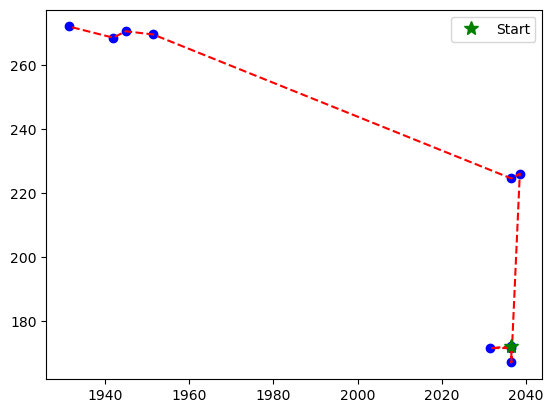

In [43]:
plot_trajectory(mip3['traces'][23]['boxes'])

In [26]:
anim = animate_frames(mip3['trace_videos'][12])
HTML(anim.to_html5_video())

In [36]:
j = 9
demo_vid = mip3['traces'][9]['patches']

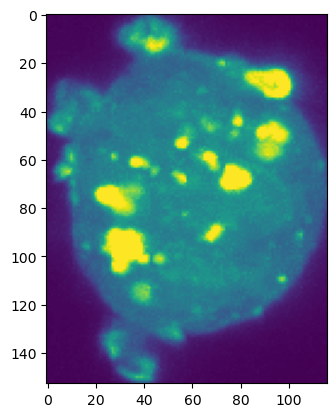

In [40]:
imshow(demo_vid[0])

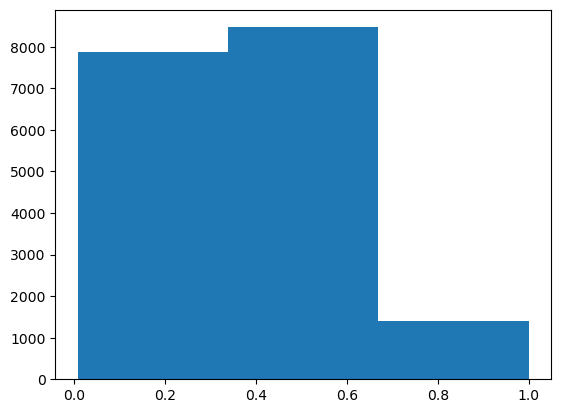

In [54]:
pix = demo_vid[0].flatten()

n, bins, fig = plt.hist(pix, bins=3, density=False)

In [55]:
bins

array([0.00742741, 0.33828494, 0.66914247, 1.        ])

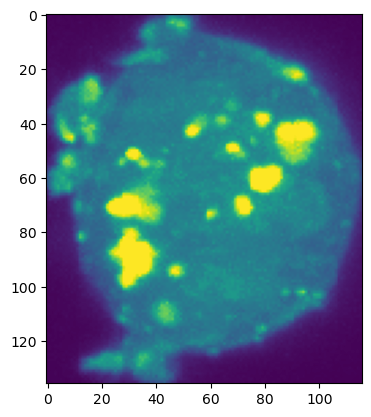

In [65]:
imshow(demo_vid[3])

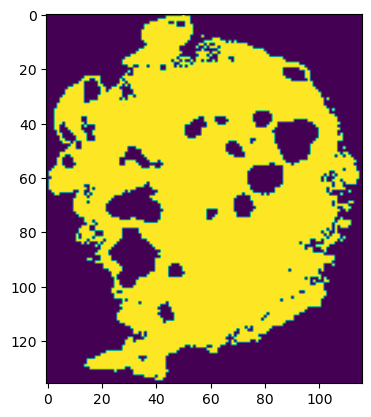

In [66]:
imshow(np.logical_and(0.338 < demo_vid[3], demo_vid[3] < 0.67))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])